Import initial dependencies

In [5]:
%matplotlib inline

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as dset
import seaborn as sns

import matplotlib as mpl
import matplotlib.pyplot as plt

In [6]:
mpl.rc('font', size=15)
mpl.rc('figure', figsize=(8, 5))

## Download MNIST dataset and import into Pytorch DataLoader

In [7]:
def setup_data_loaders(batch_size=128):
    
    # Download dataset
    root = './data'
    download = True
    trans = transforms.ToTensor()
    train_set = dset.MNIST(root=root, train=True, download=download,
                           transform=trans)
    test_set = dset.MNIST(root=root, train=False, transform=trans)
    
    # Setup dataloader
    train_loader = torch.utils.data.DataLoader(
        dataset=train_set, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(
        dataset=test_set, batch_size=batch_size, shuffle=False)
    
    return train_loader, test_loader

train_loader, test_loader = setup_data_loaders()

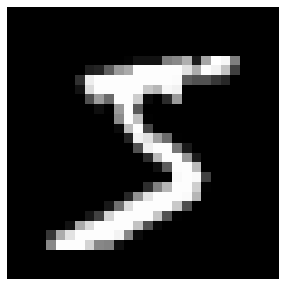

Label: 5


In [8]:
def show_image(x, save=None):
    ''' Convienent function to plot MNIST image from numpy array'''
    if isinstance(x, torch.Tensor):
        x = x.detach().numpy()
    x = x.reshape(28, 28)
    
    plt.figure()
    plt.imshow(x, cmap='gray', vmin=0, vmax=1)
    plt.axis('off')
    if save is not None:
        plt.savefig(save, dpi=300)
    plt.show()
    
# show the first image
x, y = train_loader.dataset[0]

show_image(x)

print('Label: {}'.format(y))

## Train a simple CNN

In [11]:
def conv_dim(kernel, pad, dim=28):
    return 28 + 2 * pad - kernel + 1

class CNN(nn.Module):
    def __init__(self, conv_filter, hidden_size):
        super().__init__()
        
        self.conv = nn.Conv2d(1, conv_filter, 5, padding=2)
        self.maxpool = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(14 * 14 * conv_filter, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 10)
        
        self.relu = nn.ReLU()
        self.log_softmax = nn.LogSoftmax(dim=1)
        self.conv_filter = conv_filter
        
    def forward(self, x):
        x = self.relu(self.conv(x))
        x = self.maxpool(x)
        x = x.view(-1,  14 * 14 * self.conv_filter)
        x = self.relu(self.fc1(x))
        x = self.log_softmax(self.fc2(x))
        return x
    
net = CNN(8, 32)
optimizer = optim.Adam(net.parameters(), lr=0.03)
criterion = nn.CrossEntropyLoss(reduction='sum')

Start training

In [12]:
max_epochs = 5

print('Start training')
for epoch in range(max_epochs):
    train_loss = 0
    for i_batch, (x_data, y_data) in enumerate(train_loader):
        optimizer.zero_grad()
        yhat = net(x_data)
        loss = criterion(yhat, y_data)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
    train_loss = train_loss / len(train_loader.dataset)
    print("Epoch {}: Loss {}".format(epoch, train_loss))

Start training
Epoch 0: Loss 0.1865922105272611
Epoch 1: Loss 0.10187151569724083
Epoch 2: Loss 0.08969498289351661
Epoch 3: Loss 0.09500042453669011
Epoch 4: Loss 0.09053395722359418


## Train a simple FC BNN

Import Pyro dependencies

In [13]:
import pyro
import pyro.distributions as dist
from pyro.nn import PyroSample, PyroModule
from pyro.infer.autoguide import AutoDiagonalNormal
from pyro.infer import SVI, Trace_ELBO

pyro.enable_validation(True)
pyro.set_rng_seed(4042)  # set RNG seed

In [14]:
class BayesNN(PyroModule):
    def __init__(self, hidden_size):
        super().__init__()
        
        # linear layer with weight and bias sampled from a Gaussian prior
        self.fc = PyroModule[nn.Linear](784, hidden_size)
        self.fc.weight = PyroSample(dist.Normal(0., 1.).expand([hidden_size, 784]).to_event(2))
        self.fc.bias = PyroSample(dist.Normal(0., 10.).expand([hidden_size]).to_event(1))
        
        # output layer with weight and bias sampled from a Gaussian prior
        self.out = PyroModule[nn.Linear](hidden_size, 10)
        self.out.weight = PyroSample(dist.Normal(0., 1.).expand([10, hidden_size]).to_event(2))
        self.out.bias = PyroSample(dist.Normal(0., 10.).expand([10]).to_event(1))
        
        # non-linear activation function
        self.relu = nn.ReLU()
        self.log_softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, x, y=None):
        x = x.reshape(-1, 784)
        x = self.relu(self.fc(x))
        x = self.log_softmax(self.out(x))

        # Define likelihood P(y | w)
        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Categorical(logits=x), obs=y)
        return x

In [15]:
# Define model and guide function
bayes_net = BayesNN(400)
guide = AutoDiagonalNormal(bayes_net)

print(bayes_net)
print(guide)

# Define SVI and optimizer
pyro.clear_param_store()
optimizer = pyro.optim.Adam({"lr": 0.03})
svi = SVI(bayes_net, guide, optimizer, loss=Trace_ELBO())

BayesNN(
  (fc): PyroLinear(in_features=784, out_features=400, bias=True)
  (out): PyroLinear(in_features=400, out_features=10, bias=True)
  (relu): ReLU()
  (log_softmax): LogSoftmax(dim=1)
)
AutoDiagonalNormal()


Start training

In [16]:
max_epochs = 5

print('Start training')
for epoch in range(max_epochs):
    train_loss = 0
    for i_batch, (x_data, y_data) in enumerate(train_loader):
        # calculate the loss and take a gradient step
        train_loss += svi.step(x_data, y_data)
    train_loss = train_loss / len(train_loader.dataset)
    print("Epoch {}: Loss {}".format(epoch, train_loss))

Start training
Epoch 0: Loss 427.1018519284566
Epoch 1: Loss 87.34109033679962
Epoch 2: Loss 83.10549624932607
Epoch 3: Loss 79.01871994978586
Epoch 4: Loss 77.43087399724324


In [17]:
guide.requires_grad_(False)
for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name))

AutoDiagonalNormal.loc Parameter containing:
tensor([-0.1545, -0.1300,  0.0337,  ..., -0.6546,  0.0781,  6.0563])
AutoDiagonalNormal.scale tensor([0.9895, 0.9428, 0.9070,  ..., 1.1429, 1.3491, 0.8762])


## Inference

Bayesian CNN inference

In [19]:
from pyro.infer import Predictive

# Create prediction model with 100 samples
return_sites = ("_RETURN", )
num_samples = 100
predictive = Predictive(
    bayes_net, guide=guide, num_samples=num_samples, return_sites=return_sites)

def bayes_predict(x):
    ''' Convenient prediction function using the Bayseian NN '''
    with torch.no_grad():
        yhat = predictive(x)['_RETURN']
        yhat = torch.mean(yhat, 0)
        return torch.argmax(yhat, 1)
    
# Evaluate performance on test set
correct = 0
total = 0
with torch.no_grad():
    for i, (x_data, y_data) in enumerate(test_loader):
        yhat_data = bayes_predict(x_data)
        total += y_data.size(0)
        correct += (yhat_data == y_data).sum().item()
    
print("accuracy: %d %%" % (100 * correct / total))

accuracy: 88 %


Traditional CNN inference

In [20]:
def predict(x):
    ''' Covenient prediction function using the traditional NN '''
    with torch.no_grad():
        yhat = net(x)
        return torch.argmax(yhat, 1) 
    
# Evaluate performance on test set
correct = 0
total = 0
with torch.no_grad():
    for i, (x_data, y_data) in enumerate(test_loader):
        yhat_data = predict(x_data)
        total += y_data.size(0)
        correct += (yhat_data == y_data).sum().item()
    
print("accuracy: %d %%" % (100 * correct / total))

accuracy: 97 %


## Inference on different datasets

In [21]:
def plot_barplot(x, save=None):
    ''' Convenient function for bar plot '''
    yhat = predictive(x)['_RETURN'].detach().numpy()
    yhat = np.argmax(np.squeeze(yhat), 1)
    labels = np.arange(10)
    counts = np.bincount(yhat, minlength=10)
    
    
    plt.figure()
    sns.barplot(labels, counts)
    plt.xlabel('Label')
    plt.ylabel('Count')
    if save is not None:
        plt.savefig(save, dpi=300)
    plt.show()

### MNIST Image

Prediction: 7
Label 7


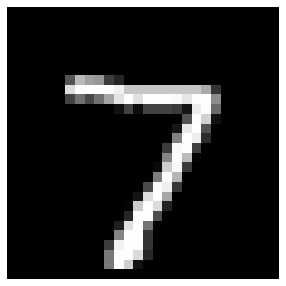

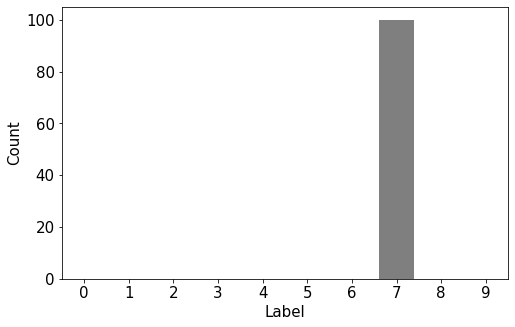

In [44]:
x, y = test_loader.dataset[0]
x = x.view(1, 1, 28, 28)

print('Prediction: {}'.format(predict(x).numpy()[0]))
print('Label {}'.format(y))

show_image(x, save='ex.png')
plot_barplot(x, save='barplot_ex.png')

### Random noise image

Prediction: 9


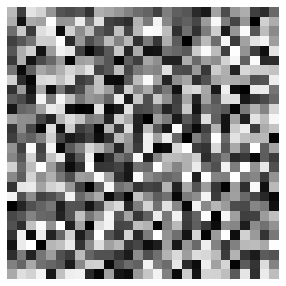

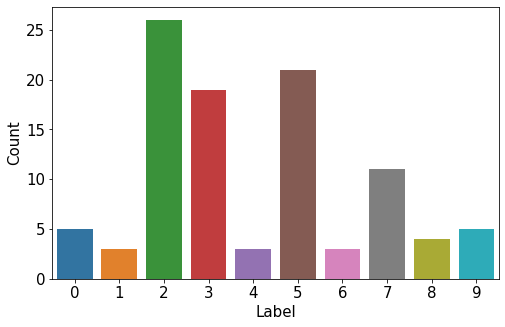

In [45]:
x = torch.rand(1, 1, 28, 28)

print('Prediction: {}'.format(predict(x).numpy()[0]))

show_image(x, save='noise.png')
plot_barplot(x, save='barplot_noise.png')

### Image from URL

In [46]:
from PIL import Image
import requests
from io import BytesIO

url = 'https://images.unsplash.com/photo-1482786951817-f26b90cfb79c?ixlib=rb-1.2.1&auto=format&fit=crop&w=1000&q=80'
response = requests.get(url)
img = Image.open(BytesIO(response.content)).convert('L')
img = img.resize((28, 28))

Prediction: 9


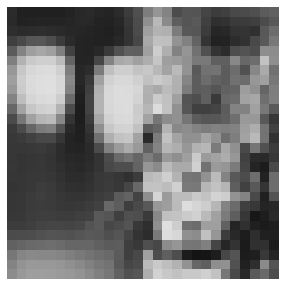

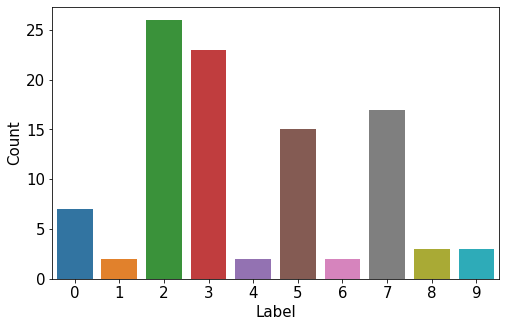

In [47]:
trans = transforms.ToTensor()
x = transforms.ToTensor()(img)
# x = 1 - x
x = x.view(1, 1, 28, 28)

print('Prediction: {}'.format(predict(x).numpy()[0]))

show_image(x)
plot_barplot(x)

## Adversarial

In this example, we use adversarial technique to trick the traditional CNN into mislabeling two almost identical images.

In [48]:
from torch.autograd import Variable,grad

Create and test on adversarial example

In [61]:
# select a random MNIST image, here the label is 1
x_target, _ = test_loader.dataset[2]
x_target = x_target.view(1, 1, 28, 28)

# create an advesarial image
x = torch.normal(.5, .3, (1, 1, 28, 28), requires_grad=True)
y = torch.tensor([7])    # what the mislabel will be

# adversarial parameters that control the gradient upgrade (similar to learning rate)
eta = 0.1
lam = 0.05

# Gradient descent on the input
steps = 1000
for i in range(steps):
    yhat = net(x)
    loss = criterion(yhat, y)
    
    # Calculate the derivative
    g = grad(loss, x, retain_graph=True, allow_unused=True)
    g = g[0]

    # The GD update on x, with an added penalty 
    # to the cost function
    x = x - eta * (g + lam * (x - x_target))

The first image is the adversarial image of the second image. Although they look identical to the human eyes, the noise added into the adversarial image will make the traditional CNN mislabel it to 7 (instead of 1)

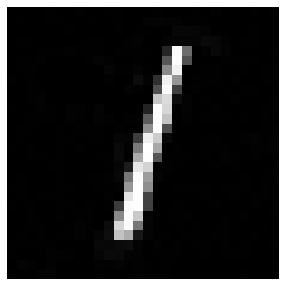

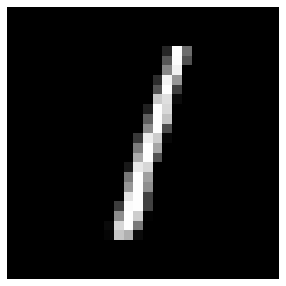

In [62]:
show_image(x, save='adv1.png')
show_image(x_target, save='adv_target1.png')

The Bayes CNN, however, is not fooled by such treachery

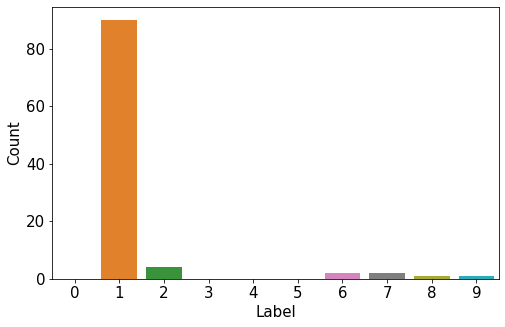

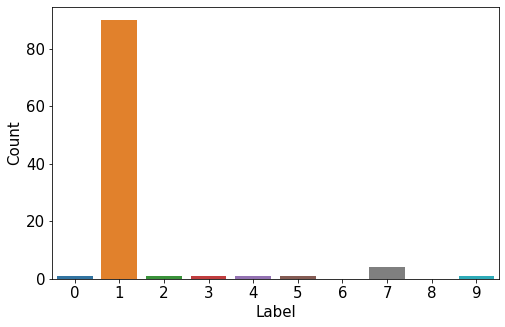

In [63]:
plot_barplot(x, save='adv_barplot1.png')
plot_barplot(x_target, save='adv_target_barplot1.png')

In [58]:
print('Prediction: {}'.format(predict(x).numpy()[0]))
print('Prediction: {}'.format(predict(x_target).numpy()[0]))

Prediction: 7
Prediction: 1
